<h1> Computing Sensitivity (Sobol) Indices For a Piston Model

<h4> By Pranay Seshadri </h4>

In many computational problems there are a few key inputs that actually dictate the state of the output. Computing the Sobol indices of the inputs is one approach to determine which inputs are the $\textit{drivers}$. Typically computation of the Sobol indices involves a large number of samples -- significantly more than required to get the variance in the data. However as shown in Blatman et al. [1], using orthogonal polynomials these can be computed with relative ease. In this notebook we demonstrate how we can compute these indices using effective quadratures. 

We consider the well-known piston problem from Kenett et al. [2] that is a non-linear, seven-dimensional problem that outputs the piston cycle time given various piston parameters. These parameters and their bounds are shown in the table below.

$$\begin{array}{lll} \hline
Variable & Range & Description \\ \hline
M & [30, 60] & Piston \; weight \; (kg)\\ 
S & [0.005, 0.0020] & Piston \; surface \; area \; (m^2)\\ 
V_0 & [0.002, 0.010] & Initial \; gas \; volume \; (m^3)\\ 
k & [1000,5000] & Spring \; coefficient \; (N/m)\\ 
P_0 & [90000, 110000] & Atmospheric \; pressure \; (N/m^2)\\ 
T_a & [290, 296] & Ambient \; temperature \; (K)\\ 
T_0 & [340, 360] & Filling \; gas \; temperature \; (K)\\ \hline
\end{array}$$

The cycle time for the piston is given by
$$C=2\pi\sqrt{\frac{M}{k+S^{2}\frac{P_{0}V_{0}T_{a}}{T_{0}V^{2}}}},$$
where
$$V=\frac{S}{2k}\left(\sqrt{A^{2}+4k\frac{P_{0}V_{0}}{T_{0}}T_{a}}-A\right),$$
and
$$A=P_{0}S+19.62M-\frac{kV_{0}}{S}.$$
The estimated $\textit{normalized}$ Sobol indices from Owen et al. [3] are given to be:

$$\begin{array}{lllllll} \hline
  & M &  S & V_0 & k & P_0 & T_a & T_0  \\ \hline
10^2 \underline{\tau^{(2)}} \; indices & 0.073 & 1.088 & 0.626 & 0.040 & 0.001 & -0.002 & -0.002 \\ \hline
\end{array}$$

Note that these values are effectively the Sobol index multiplied by the variance. See [3] for further details.

In [1]:
%matplotlib inline
from equadratures import *
import numpy as np

As before, we begin by defining each parameter and its range using four points for each variable.

In [2]:
order_parameters = 3
mass = Parameter(distribution='uniform', lower=30.0, upper=60.0, order=order_parameters)
area = Parameter(distribution='uniform', lower=0.005, upper=0.020, order=order_parameters)
volume = Parameter(distribution='uniform', lower=0.002, upper=0.010, order=order_parameters)
spring = Parameter(distribution='uniform', lower=1000., upper=5000., order=order_parameters)
pressure = Parameter(distribution='uniform', lower=90000., upper=110000., order=order_parameters)
ambtemp = Parameter(distribution='uniform', lower=290., upper=296., order=order_parameters)
gastemp = Parameter(distribution='uniform', lower=340., upper=360., order=order_parameters)
parameters = [mass, area, volume, spring, pressure, ambtemp, gastemp]

def piston(x):
    mass, area, volume, spring, pressure, ambtemp, gastemp = x[0], x[1], x[2], x[3], x[4], x[5], x[6]
    A = pressure * area + 19.62*mass - (spring * volume)/(1.0 * area)
    V = (area/(2*spring)) * ( np.sqrt(A**2 + 4*spring * pressure * volume * ambtemp/gastemp) - A)
    C = 2 * np.pi * np.sqrt(mass/(spring + area**2 * pressure * volume * ambtemp/(gastemp * V**2)))
    return C

We will opt for a total order basis set with effective quadrature subsampling!

In [3]:
mybasis = Basis('Total order')
Pleastsquares = Polylsq(parameters, mybasis, mesh='tensor', optimization='greedy-qr', oversampling=1.0)

Now (and this is the important part), we wish to ascertain how many model evaluations will be required for computing these sensitivities. The objective is for these to be orders of magnitude lower than other methods for computing Sobol' indices.

In [4]:
print mybasis.cardinality

120


Excellent! So the number of model evaluations we will require is 120! Now lets compute the coefficients and ascertain which of the variables above are the most important.

In [5]:
Pleastsquares.computeCoefficients(piston)
Sleastsquares = Pleastsquares.getStatistics()

//anaconda/lib/python2.7/site-packages/equadratures-6.0-py2.7.egg/equadratures/polylsq.py:208: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  alpha = np.linalg.lstsq(self.Az, self.bz)


Printing the output to the screen...and verifying the values are similar to the ones reported by Owen...

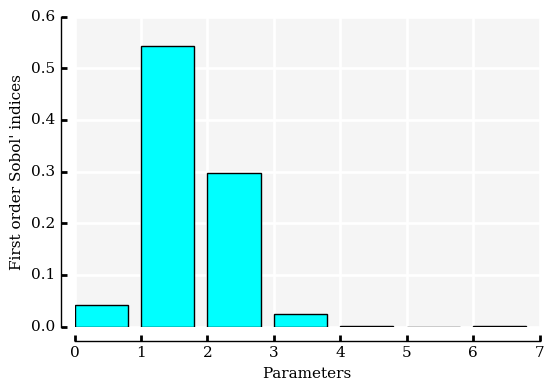

In [6]:
data = Sleastsquares.getSobol(1)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
for key, value in data.items():
    plt.bar(key[0], value, color='aqua')
adjust_spines(ax, ['left', 'bottom'])
plt.xlabel("Parameters")
plt.ylabel("First order Sobol' indices")
plt.show()

In [7]:
data = Sleastsquares.getSobol(1).values()
for i in range(0, len(parameters)):
    print float(data[i]) * 10**2 * Sleastsquares.variance

0.0790729230512
1.04006909416
0.570479600289
0.047655149298
0.00307211809197
5.74465327578e-05
0.00180048511613


Yes they are, voila! And we are done here!

<h3> References

1. Blatman, Géraud, and Bruno Sudret. "Adaptive sparse polynomial chaos expansion based on least angle regression." Journal of Computational Physics 230.6 (2011): 2345-2367.
2. Kenett, Ron, Shelemyahu Zacks, and Daniele Amberti. Modern Industrial Statistics: with applications in R, MINITAB and JMP. John Wiley & Sons, 2013.
3. Owen, Art B., Josef Dick, and Su Chen. "Higher order Sobol'indices." Information and Inference 3.1 (2014): 59-81.